In [2]:
import os
import networkx as nx
import pickle
import itertools
import pandas as pd
import json
from tqdm.notebook import tqdm
import numpy as np

import pdod_func
import multiprocessing


import scipy.stats
import statsmodels.api as sm
import csv


# Functions
negative edges and genes generator

PDOD path_length (conflict resolve), if there are no path between nodes, it makes 'inf'

PDOD score function

In [3]:
def conflict_resolve(path_network, path_generator):
  n_pos_path = 0
  n_neg_path = 0  
  path_list = [path for path in path_generator]

  for path in path_list:
    pos_neg_value = 0
    for i in range(len(path)-1):
      if path_network[path[i]][path[i+1]]['sign'] == 'negative':
        pos_neg_value += 1
    if pos_neg_value % 2 == 0:
      n_pos_path +=1
    else:
      n_neg_path +=1
  
  if not n_pos_path == n_neg_path:
    path_length = (len(path_list[0])-1) * (n_pos_path + n_neg_path) / (n_pos_path - n_neg_path)
  else:
    path_length = float('inf')
  
  return path_length


In [4]:
def pdod_score(drug_target_dict, disease_gene_dict, path_network, bell_parameter):
    disease_gene_count = len([disease_gene for disease_gene in disease_gene_dict.keys() if disease_gene in path_network])
    drug_target_count = len([drug_target for drug_target in drug_target_dict.keys() if drug_target in path_network])
    normalize = drug_target_count*disease_gene_count
    if normalize == 0: # this is None value
        return 0

    result = 0
    for relation in itertools.product(list(drug_target_dict.keys()), list(disease_gene_dict.keys())):
        source, target = relation
        if source in path_network and target in path_network:
            if nx.has_path(path_network, source = source, target=target):
                path_list = [path for path in nx.all_shortest_paths(path_network, source = source, target=target)]
                path_length = conflict_resolve(path_network, path_list)
            else:
                path_length = float('inf')

            drug_target_sign = 0
            if drug_target_dict[source] == 'positive':
                drug_target_sign = 1
            else:
                drug_target_sign = -1

            disease_gene_sign = 0
            if disease_gene_dict[target] == 'negative':
                disease_gene_sign = 1
            else:
                disease_gene_sign = -1

            sign = drug_target_sign * disease_gene_sign * np.sign(path_length)

            bell_shape = 1 / (1 + abs(path_length/bell_parameter) ** 2)

            result += sign * bell_shape

    result = result / normalize

    return result


# GEO parsing function

In [5]:
def get_annotation(gene_dataframe, data_flatform, leftkey):
  gene_annotated = gene_dataframe.reset_index().merge(gse.gpls[data_flatform].table[["ID", "ENTREZ_GENE_ID", "Gene Symbol"]],
                                left_on=leftkey, right_on="ID").set_index(leftkey)
  del gene_annotated["ID"]
  # remove probes without ENTREZ
  gene_annotated = gene_annotated.dropna(subset=["ENTREZ_GENE_ID"])
  # remove probes with more than one gene assigned
  gene_annotated['ENTREZ_GENE_ID'] = pd.to_numeric(gene_annotated['ENTREZ_GENE_ID'], errors="coerce")
  gene_annotated.dropna(how="any", inplace=True)
  gene_annotated['ENTREZ_GENE_ID'] = gene_annotated.ENTREZ_GENE_ID.astype('int').astype('str')
  # for each gene average LFC over probes
  gene_annotated = gene_annotated.groupby("Gene Symbol").median()

  return gene_annotated

In [6]:
def get_lfc(control_samples, post_samples):
  control_mean = np.log2(control_samples.mean(axis=1))
  post_mean = np.log2(post_samples.mean(axis=1))
  LFCs = pd.DataFrame({"LFC": (post_mean - control_mean).to_dict()})
  return LFCs

In [7]:
def get_ttest(control_samples, post_samples):
    ttest_result = scipy.stats.ttest_ind(control_samples, post_samples, axis=1)
    p_val_list = ttest_result[1]
    fdrcorrection = sm.stats.fdrcorrection(p_val_list)
    FDR_pass_fail = fdrcorrection[0]
    corrected_p_val = fdrcorrection[1]
    ttest = pd.DataFrame({"stat": ttest_result[0], "pvalue": ttest_result[1], "FDR": corrected_p_val, "P/F": FDR_pass_fail}, index=control_samples.index)
    return ttest

## GSE68719 / kings college

### remove row at 60% of 0 counts

In [15]:
with open('gene_expression_data/GSE68719_TPM_DF.p', 'rb') as f:
  total_DF =  pickle.load(f)

total_DF = total_DF[total_DF.astype('bool').mean(axis=1)>=0.4]

index_list = total_DF.index
index_list = [target_id.split('|')[-4] for target_id in index_list]
total_DF.insert(loc=0, column='Gene Symbol', value=index_list)

total_DF = total_DF.reset_index(drop=True)
total_DF = total_DF.groupby("Gene Symbol").median()

normal_samples = total_DF[total_DF.columns[:44]]
parkinson_smaples = total_DF[total_DF.columns[44:]]

KL_LFCs = get_lfc(normal_samples, parkinson_smaples)
KL_FDR = get_ttest(normal_samples, parkinson_smaples)

# Network parsing

필요한 정보들
1. Network (intersection between Pathway commons and ARN)
2. gene expression 방향 (Core Genes)
3. Drug activation 정보

## Pathway commons network (directed)

### load

In [8]:
with open('network_data/pc_di_digraph.p', 'rb') as f:
    directed_PC = pickle.load(f)

In [9]:
print(len(directed_PC.nodes()))
print(len(directed_PC.edges()))

16891
460033


## KEGG

### Load

In [10]:
with open('network_data/KEGG_graph.p', 'rb') as f:
    KEGG_graph = pickle.load(f)

In [11]:
print(len(KEGG_graph.nodes()))
print(len(KEGG_graph.edges()))

5117
9820


In [12]:
pos_count = 0
neg_count = 0
for edge in KEGG_graph.edges():
    edge_sign = KEGG_graph[edge[0]][edge[1]]['sign']
    if edge_sign == 'positive':
        pos_count += 1
    elif edge_sign == 'negative':
        neg_count += 1

print(pos_count)
print(neg_count)

7697
2123


## Backbone network (PC + KEGG)

In [16]:
# filtering backbone by gene expression

filtered_backbone_network = nx.DiGraph()
for edge in list(directed_PC.edges):
    if edge[0] in KL_LFCs.index and edge[1] in KL_LFCs.index:
        filtered_backbone_network.add_edge(edge[0], edge[1], sign = 'associate')
            
for edge in list(KEGG_graph.edges):
    if edge[0] in KL_LFCs.index and edge[1] in KL_LFCs.index:
        if filtered_backbone_network.has_edge(edge[0], edge[1]):
            filtered_backbone_network[edge[0]][edge[1]]['sign'] = KEGG_graph[edge[0]][edge[1]]['sign']
        else:
            filtered_backbone_network.add_edge(edge[0], edge[1], sign = KEGG_graph[edge[0]][edge[1]]['sign'])

In [17]:
print(len(filtered_backbone_network.edges))
print(len(filtered_backbone_network.nodes))

391789
15328


## ARN core genes with expression sign

LFC log값이 음수면 down regulated된 거로 취급

In [18]:
ARN_core = pd.read_csv('Gene_data/autophagy_proteins_ARN.csv')

In [19]:
len(ARN_core)

37

In [20]:
def added_ARN_core_sign(added_ARN_core, LFCs):
    ARN_core_nodes = dict()
    for gene in added_ARN_core:
        if gene in LFCs.index:
            if LFCs.loc[gene, 'LFC'] < 0:
                ARN_core_nodes[gene] = 'negative'
            else:
                ARN_core_nodes[gene] = 'positive'
    
    return ARN_core_nodes

In [21]:
def ARN_core_sign_FDR(ARN_core, LFCs, backbone_network, FDR_df):
    ARN_core_nodes = dict()
    for index, row in ARN_core.iterrows():
        gene_name = row['Gene_symbol']
        if gene_name in LFCs.index and gene_name in backbone_network and gene_name in FDR_df.index and FDR_df.loc[gene_name]['P/F']:
            if LFCs.loc[gene_name, 'LFC'] < 0:
                ARN_core_nodes[gene_name] = 'negative'
            else:
                ARN_core_nodes[gene_name] = 'positive'
    
    return ARN_core_nodes

In [250]:
def add_RWR_genes_FDR(core_gene_FDR, backbone_network, FDR_df):
    interesting_genes = [gene for gene in core_gene_FDR.keys()]

    all_genes_in_network = set(backbone_network.nodes())
    interesting_genes = set(interesting_genes)
    interesting_genes = interesting_genes & all_genes_in_network
    
    start_nodes = dict()
    for gene in interesting_genes:
      start_nodes[gene] = 1

    pr = nx.pagerank(backbone_network, personalization=start_nodes)
    
    sorted_rwr = sorted(pr.items(), key=lambda item: item[1], reverse=True)
    rwr_score_list = [gene[1] for gene in sorted_rwr]
    rwr_score_list = np.array(rwr_score_list)
    rwr_score_list = (rwr_score_list - rwr_score_list.mean())/rwr_score_list.std()
    rwr_p_value_list = scipy.stats.norm.sf(rwr_score_list)
    added_core_genes = [gene[0] for gene in sorted_rwr if gene[0] in interesting_genes]

    for i in range(len(sorted_rwr)):
        test_gene = sorted_rwr[i]
        if test_gene[0] in added_core_genes:
            continue    
        else:
            if test_gene[0] in KL_FDR.index and KL_FDR.loc[test_gene[0]]['P/F'] and rwr_p_value_list[i] < 0.05:
                added_core_genes.append(test_gene[0])
                print(test_gene[0], rwr_p_value_list[i])
    return added_core_genes

In [251]:
# Get sign of Genes
KL_ARN_core_nodes_FDR = ARN_core_sign_FDR(ARN_core, KL_LFCs, filtered_backbone_network, KL_FDR)
# Add RWR algorithm
added_core_genes_FDR = add_RWR_genes_FDR(KL_ARN_core_nodes_FDR, filtered_backbone_network, KL_FDR)

NRBF2 0.0
PTK2 0.0007771433658386994
ACTR2 0.04771191494879311


In [37]:
interesting_genes = [gene for gene in KL_ARN_core_nodes_FDR.keys()]

all_genes_in_network = set(filtered_backbone_network.nodes())
interesting_genes = set(interesting_genes)
interesting_genes = interesting_genes & all_genes_in_network

start_nodes = dict()
for gene in interesting_genes:
  start_nodes[gene] = 1

pr = nx.pagerank(filtered_backbone_network, personalization=start_nodes)
sorted_rwr = sorted(pr.items(), key=lambda item: item[1], reverse=True)
rwr_score_list = [gene[1] for gene in sorted_rwr]
rwr_score_list = np.array(rwr_score_list)
rwr_score_list = (rwr_score_list - rwr_score_list.mean())/rwr_score_list.std()
rwr_p_value_list = scipy.stats.norm.sf(abs(rwr_score_list))

added_core_genes = [gene[0] for gene in sorted_rwr if gene[0] in interesting_genes]



for i in range(len(sorted_rwr)):
    test_gene = sorted_rwr[i]
    if test_gene[0] in added_core_genes:
        continue    
    else:
        if test_gene[0] in KL_FDR.index and KL_FDR.loc[test_gene[0]]['P/F'] and rwr_p_value_list[i] < 0.05:
            added_core_genes.append(test_gene[0])

In [28]:
rwr_score_list = [gene[1] for gene in sorted_rwr]

In [30]:
rwr_score_list = np.array(rwr_score_list)
rwr_score_list = (rwr_score_list - rwr_score_list.mean())/rwr_score_list.std()

In [175]:
# Check sign of genes
KL_added_core_nodes_FDR = added_ARN_core_sign(added_core_genes_FDR, KL_LFCs)
print(KL_added_core_nodes_FDR)

{'PIK3R4': 'negative', 'ATG14': 'negative', 'FYCO1': 'positive', 'NRBF2': 'negative', 'PTK2': 'negative', 'ACTR2': 'negative'}


## Drugbank drug-gene load


### relation load

In [72]:
with open('drug_data/drug_target.pickle', 'rb') as f:
  drug_dict = pickle.load(f)

In [19]:
count = 0
target_list = list()
zero_count = 0
pos_count = 0
neg_count = 0
for drug in drug_dict:
    target_list += list(drug_dict[drug].keys())
    count += len(drug_dict[drug])
    for gene in drug_dict[drug]:
        if drug_dict[drug][gene] == 'positive':
            pos_count+=1
        elif drug_dict[drug][gene] == 'negative':
            neg_count+=1
print(len(drug_dict))
print(count)
print(len(set(target_list)))
print(zero_count)
print(pos_count)
print(neg_count)

7486
9972
2057
0
2539
7433


In [11]:
relation_list = list()
for drug in drug_dict:
    target_list += list(drug_dict[drug].keys())
    count += len(drug_dict[drug])
    for gene in drug_dict[drug]:
        relation_list.append(drug_dict[drug][gene])

In [15]:
relation_list = [relation for relation in relation_list if len(relation)!=0]

In [16]:
len(relation_list)

9972

## Drugbank drug-indication relation load

In [28]:
drug_indi_dict = dict()

for drug in tqdm(drug_list):
    with open(drug_bank_path + drug) as json_file:
        drug_info = json.load(json_file)
    name = drug_info['name']
    structured_indications = drug_info['pharmacology']['structured_indications']
  
    indication_list = list()
    if len(structured_indications) > 0:
        for indication in structured_indications:
            indication_info = dict()
            if 'condition' in indication.keys():
                condition = indication['condition']
                indication_info['drugbank_id'] = condition['drugbank_id']
                indication_info['name'] = condition['title']
                indication_info['kind'] = indication['kind']
                indication_list.append(indication_info)

    drug_indi_dict[name] = indication_list


  0%|          | 0/13581 [00:00<?, ?it/s]

UnicodeDecodeError: 'cp949' codec can't decode byte 0xe2 in position 169434: illegal multibyte sequence

In [ ]:
with open('drug_data/drug_indication.pickle', 'wb') as f:
    pickle.dump(drug_indi_dict, f)

### relation load

In [254]:
with open('drug_data/drug_indication.pickle', 'rb') as f:
  drug_indi_dict = pickle.load(f)

In [258]:
kind_set = list()
for drug in drug_indi_dict:
    kind_list = [indi['kind'] for indi in drug_indi_dict[drug]]
    kind_set += kind_list
kind_set = set(kind_set)
kind_set

{'adjunct_for_therapy',
 'adjunct_therapy_in_management_of',
 'adjunct_therapy_in_prevention_of',
 'adjunct_therapy_in_prophylaxis_of',
 'adjunct_therapy_in_treatment_of',
 'diagnostic_agent',
 'diagnostic_process',
 'for_therapy',
 'induction_of',
 'maintenance_of',
 'management_of',
 'prevention_of',
 'prophylaxis_of',
 'reversal_of',
 'symptomatic_treatment_of',
 'treatment_of',
 'used_as_adjunct_for_symptomatic_treatment_of',
 'used_as_adjunct_in_combination_for_prophylaxis_of',
 'used_as_adjunct_in_combination_for_symptomatic_treatment_of',
 'used_as_adjunct_in_combination_for_therapy',
 'used_as_adjunct_in_combination_to_maintain',
 'used_as_adjunct_in_combination_to_manage',
 'used_as_adjunct_in_combination_to_prevent',
 'used_as_adjunct_in_combination_to_treat',
 'used_in_combination_as_diagnostic_agent',
 'used_in_combination_for_prophylaxis_of',
 'used_in_combination_for_symptomatic_treatment_of',
 'used_in_combination_to_induce',
 'used_in_combination_to_maintain',
 'used_in

In [264]:
treatment_case = list()
for drug in drug_indi_dict:
    indications = drug_indi_dict[drug]
    treatment_list = [indi['name'] for indi in indications if 'treatment_of' in indi['kind']]
    treatment_case += treatment_list
treatment_case = set(treatment_case)
treatment_case = list(treatment_case)
treatment_case.sort()
treatment_case

['>1 micromole per liter toxic plasma methotrexate concentrations',
 'ACE Inhibitor-associated Angioedema',
 'Ab externo surgery Glaucoma',
 'Abnormal Uterine Bleeding',
 'Abrupt opioid withdrawal',
 'Abscess, Intra-Abdominal',
 'Abscess, Intra-Abdominal caused by Anaerobic Bacterial Infection',
 'Abscesses',
 'Abscesses caused by susceptible bacteria',
 'Accelerated phase chronic myologenic leukemia',
 'Acetaminophen Overdose',
 'Achalasia',
 'Acid Reflux',
 'Acid indigestion',
 'Acidosis, Renal Tubular',
 'Acinetobacter infection',
 'Acne',
 'Acne Rosacea',
 'Acne Vulgaris',
 'Acquired Coagulation Factor Deficiency',
 'Acquired immune hemolytic anemia',
 'Acromegaly',
 'Actinic Cheilitis',
 'Actinic Keratoses of the face',
 'Actinic Keratoses of the scalp',
 'Actinic Keratosis (AK)',
 'Actinomycosis',
 'Active Ankylosing Spondylitis or Non-Radiographic Axial Spondyloarthritis',
 'Active Ankylosing spondylitis',
 'Active Duodenal ulcer',
 'Active Gastric ulcer',
 'Active Tuberculosis'

In [267]:
PD_drugs = ['Amantadine',
            'Apomorphine',
            'Benserazide',
            'Biperiden',
            'Bornaprine',
            'Bromocriptine',
            'Carbidopa',
            'Droxidopa',
            'Entacapone',
            'Istradefylline',
            'Levodopa',
            'Melevodopa',
            'Opicapone',
            'Pergolide',
            'Piribedil',
            'Pramipexole',
            'Quetiapine',
            'Rasagiline',
            'Ropinirole',
            'Rotigotine',
            'Safinamide',
            'Selegiline'
]

## Run PDOD

In [44]:
def Writer(dest_filename, q, some_stop_token):
    with open(dest_filename, 'w', newline='') as dest_file:
        wr = csv.writer(dest_file)
        wr.writerow(
            ("drug name", "PDOD score"))
        while not q.empty:
            results = q.get()
            if results == some_stop_token:
                return
            else:
                wr.writerow(results)

def pdod_score_writer(some_queue, drug_name, drug_dict, core_nodes, network):
    drug_score = pdod_score(drug_dict[drug_name], core_nodes, network, 3)
    print(drug_name, drug_score)
    some_queue.put([drug_name, drug_score])

In [171]:
def PDOD(result_file, drug_dict, ARN_core_nodes, path_network):
    drug_names = [drug for drug in drug_dict.keys()]
    manager = multiprocessing.Manager()
    queue = manager.Queue()
    pool = multiprocessing.Pool(multiprocessing.cpu_count())
    STOP_TOKEN = "STOP"

    # pbar = tqdm(drug_dict.keys())
    # def update(*a):
    #     pbar.update()

    writer_process = pool.apply_async(pdod_func.Writer, ("Score_result/"+result_file, queue, STOP_TOKEN))

    processes = []
    for drug in drug_names:
        job = pool.apply_async(pdod_func.pdod_score_writer, args=(queue, drug, drug_dict, ARN_core_nodes, path_network))#, callback=update)
        processes.append(job)

    # Make sure the jobs are finished
    for process in tqdm(processes):
        process.get()

    queue.put(STOP_TOKEN)
    pool.close()
    pool.join()
    # There, your file was written.

In [46]:
# KL FDR filtered edition
PDOD('KL_added_PDOD.csv', drug_dict, KL_added_core_nodes_FDR, filtered_backbone_network)

  0%|          | 0/7486 [00:00<?, ?it/s]

In [85]:
def get_shortest_path_cytoscape(source_gene):
    shortest_path_networks = list()
    for target in target_genes:
        shortest_path_networks += [nx.subgraph(filtered_backbone_network, path) for path in nx.all_shortest_paths(filtered_backbone_network, source=source_gene, target=target)]

    shortest_paths = list()
    for target in target_genes:
        shortest_paths += [path for path in nx.all_shortest_paths(filtered_backbone_network, source=source_gene, target=target)]

    length_list = [len(path) for path in shortest_paths]
    length_list = np.array(length_list)
    print(length_list.mean())
    print(length_list.std())

    shortest_path_graph = nx.compose_all(shortest_path_networks)

    from collections import defaultdict
    shorest_path_cytoscape_dict = defaultdict(list)

    edge_sign_dict = nx.get_edge_attributes(shortest_path_graph, 'sign')
    for edge in edge_sign_dict:
        src = edge[0]
        trg = edge[1]
        sign = edge_sign_dict[edge]
        if src in source_genes:
            src_type = 'drug target'
        elif src in target_genes:
            src_type = 'autophagy'
        else:
            src_type = 'path gene'

        if trg in source_genes:
            trg_type = 'drug target'
        elif trg in target_genes:
            trg_type = 'autophagy'
        else:
            trg_type = 'path gene'

        shorest_path_cytoscape_dict['left node'].append(src)
        shorest_path_cytoscape_dict['right node'].append(trg)
        shorest_path_cytoscape_dict['left type'].append(src_type)
        shorest_path_cytoscape_dict['right type'].append(trg_type)
        shorest_path_cytoscape_dict['edge type'].append(sign)

    shorest_path_cytoscape_dataframe = pd.DataFrame(shorest_path_cytoscape_dict)
    shorest_path_cytoscape_dataframe.to_csv("Score_result/cytoscape_input_{}.tsv".format(source_gene), sep='\t', index=False)

In [83]:
target_genes = list(KL_added_core_nodes_FDR.keys())
source_genes = ['ESR1', 'NR1I2', 'LEPR']

In [86]:
for source in source_genes:
    get_shortest_path_cytoscape(source)

3.6346153846153846
0.5074640123849943
3.1914893617021276
0.3934732342320624
3.6296296296296298
0.5543196128553987
3.6605504587155964
0.4925161662924606
3.6266666666666665
0.510511725842044


## Load PDOD result

In [2]:
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
pdod_df = pd.read_csv('Score_result/KL_added_PDOD.csv', encoding='cp949', index_col=False)
pdod_df = pdod_df.loc[pdod_df['PDOD score'] != 0]
pdod_df = pdod_df.sort_values(by='PDOD score', ascending=False)

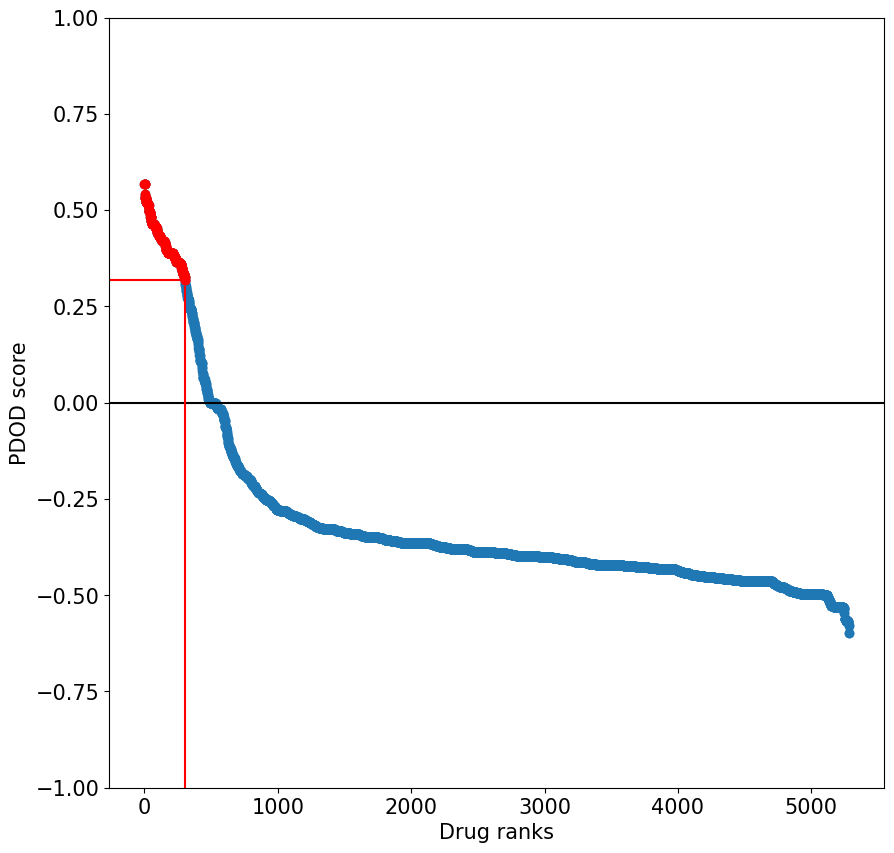

In [297]:
plt.figure(figsize=(10,10))
plt.rcParams.update({'font.size': 15})
x = np.arange(len(pdod_df))
y = pdod_df['PDOD score']
top_x = np.arange(305)
top_y = pdod_df['PDOD score'][:305]

plt.scatter(x,y)
plt.scatter(top_x,top_y, c='red')
plt.ylim(-1,1)
plt.xlabel('Drug ranks')
plt.ylabel('PDOD score')
plt.axhline(y = 0, color = 'black', linestyle = '-')
plt.axhline(y = top_y.iloc[-1], color = 'r', xmin=0, xmax=0.1)
plt.axvline(x = 305, color = 'r', ymax=0.65)

plt.savefig('PDOD score rank.png')
plt.show()

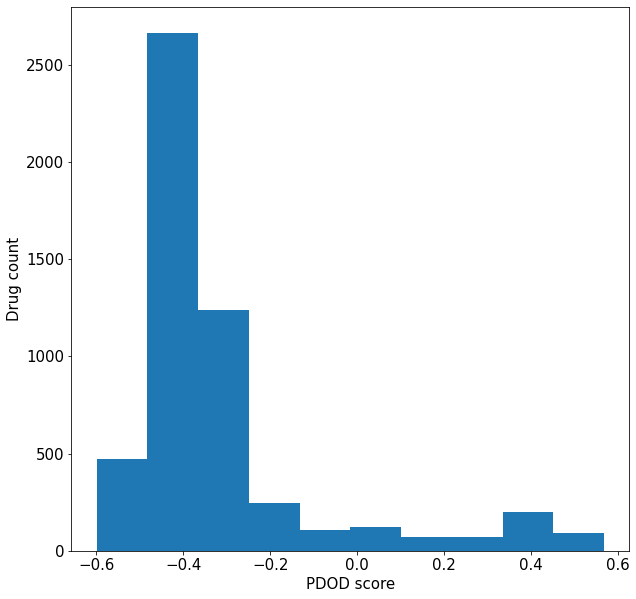

In [44]:
plt.figure(figsize=(10,10))
plt.rcParams.update({'font.size': 15})
x = pdod_df['PDOD score']

plt.hist(x)

plt.xlabel('PDOD score')
plt.ylabel('Drug count')
plt.savefig('PDOD score distribution.png')
plt.show()

# Filtering compounds with significant score

In [236]:
z_score_list = (pdod_df['PDOD score']-pdod_df['PDOD score'].mean())/pdod_df['PDOD score'].std()
p_value_list = scipy.stats.norm.sf(z_score_list)
pdod_df['PDOD p_value'] = p_value_list
pdod_df['PDOD FDR p_value'] = sm.stats.fdrcorrection(pdod_df['PDOD p_value'])[1]

In [237]:
filtered_pdod_df = pdod_df[pdod_df['PDOD FDR p_value'] < 0.05]

In [239]:
filtered_drug_list = filtered_pdod_df['drug name']

In [91]:
filtered_drug_dict = dict()
for drug in filtered_drug_list:
    filtered_drug_dict[drug] = drug_dict[drug]

In [124]:
# group drugs by target set:
def group_drugs_by_target_set(filtered_drug_dict):
    from collections import defaultdict
    target_set = list()
    for target_info in list(filtered_drug_dict.values()):
        if target_info not in target_set:
            target_set.append(target_info)

    target_set_dict = dict()
    for i in range(len(target_set)):
        target_set_dict[i] = target_set[i]

    drug_group_by_target = defaultdict(list)
    for drug in filtered_drug_dict.keys():
        target_set_index = target_set.index(filtered_drug_dict[drug])
        drug_group_by_target[target_set_index].append(drug)
    return target_set_dict, drug_group_by_target

In [147]:
def get_positive_ratio_of_targets(drug_dict):
    # count ratio of negatives and positives of drug targets
    total_sign_list = list()
    for drug in drug_dict:
        target_info = drug_dict[drug]
        sign_list = list(target_info.values())
        total_sign_list += sign_list

    positive_count = len([sign for sign in total_sign_list if sign == 'positive'])
    negative_count = len([sign for sign in total_sign_list if sign == 'negative'])
    positive_ratio = positive_count / (positive_count + negative_count)
    print(len(total_sign_list))
    print('positives:', positive_count)
    print('negatives:', negative_count)
    print('positive ratio:', positive_ratio)
    return positive_ratio

positive_ratio = get_positive_ratio_of_targets(drug_dict)

9972
positives: 2539
negatives: 7433
positive ratio: 0.2546129161652627


In [125]:
target_set_dict, drug_group_by_target = group_drugs_by_target_set(filtered_drug_dict)

In [168]:
import random

def get_random_drug_set(target_set_dict, filtered_backbone_network):
    random_drug_set = dict()
    from toolbox import wrappers, network_utilities
    n_random = 20
    min_bin_size=100
    bins = network_utilities.get_degree_binning(filtered_backbone_network, min_bin_size, None) # if lengths is given, it will only use those nodes
    for target_set in target_set_dict:
        target_list = list(target_set_dict[target_set].keys())
        target_list = [target for target in target_list if target in filtered_backbone_network]
        nodes_from_random = network_utilities.pick_random_nodes_matching_selected(filtered_backbone_network, bins, target_list, n_random, seed = 452456)

        for i, node_set in enumerate(nodes_from_random):
            node_count = len(node_set)
            sign_list = random.choices(population = ['positive', 'negative'], weights = [positive_ratio, 1-positive_ratio], k= node_count)
            random_target_info = {node_set[j]: sign_list[j] for j in range(node_count)}
            random_drug_set[str(target_set)+ '_' + str(i)] = random_target_info
    
    return random_drug_set

In [169]:
random_drug_set = get_random_drug_set(target_set_dict, filtered_backbone_network)

In [184]:
PDOD('PDOD_random_target_result.csv', random_drug_set, KL_added_core_nodes_FDR, filtered_backbone_network)

  0%|          | 0/3440 [00:00<?, ?it/s]

In [ ]:
pdod_random_df = pd.read_csv('Score_result/PDOD_random_target_result.csv', index_col=False)

In [192]:
target_group_list = [int(drug_name.split('_')[0]) for drug_name in pdod_random_df['drug name']]
pdod_random_df['target_group'] = target_group_list

In [198]:
mean_list = pdod_random_df.groupby('target_group')['PDOD score'].mean()
std_list = pdod_random_df.groupby('target_group')['PDOD score'].std()

In [241]:
drug_group_dict = dict()
for target_group in drug_group_by_target.items():
    for drug in target_group[1]:
        drug_group_dict[drug] = target_group[0]

pdod_group_list = [drug_group_dict[drug] for drug in filtered_pdod_df['drug name']]
filtered_pdod_df['target_group'] = pdod_group_list

/tmp/ipykernel_116985/1341559873.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_pdod_df['target_group'] = pdod_group_list


In [242]:
pdod_score_list = filtered_pdod_df['PDOD score']
z_scores = []
for i in range(len(filtered_pdod_df)):
    group_number = filtered_pdod_df['target_group'].iloc[i]
    group_mean = mean_list[group_number]
    group_std = std_list[group_number]
    z_score = (filtered_pdod_df['PDOD score'].iloc[i] - group_mean) / group_std
    z_scores.append(z_score)
filtered_pdod_df['PDOD proximity'] = z_scores

/tmp/ipykernel_116985/518226870.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_pdod_df['PDOD proximity'] = z_scores


In [243]:
filtered_pdod_df.sort_values('PDOD score', ascending=False)

,drug name,PDOD score,PDOD p_value,PDOD FDR p_value,target_group,PDOD proximity
235,Chlorotrianisene,0.567918,0.000056,0.022215,0,8.211945
3754,Quinestrol,0.567918,0.000056,0.022215,0,8.211945
1215,Mestranol,0.567918,0.000056,0.022215,0,8.211945
6886,Polyestradiol phosphate,0.567918,0.000056,0.022215,0,8.211945
880,Ethinylestradiol,0.541010,0.000089,0.022215,1,16.515266
...,...,...,...,...,...,...
6878,Seractide acetate,0.327825,0.002434,0.042720,168,14.992934
7331,Lutetium Lu 177 dotatate,0.326927,0.002464,0.042959,169,24.164665
6767,Somatostatin,0.326927,0.002464,0.042959,169,24.164665
638,Ergotamine,0.319436,0.002727,0.047383,170,23.662410


In [247]:
filtered_pdod_df['PDOD proximity p_value'] = stat.sm.nor.filtered_pdod_df['PDOD proximity']

,drug name,PDOD score,PDOD p_value,PDOD FDR p_value,target_group,PDOD proximity
235,Chlorotrianisene,0.567918,0.000056,0.022215,0,8.211945
6886,Polyestradiol phosphate,0.567918,0.000056,0.022215,0,8.211945
3754,Quinestrol,0.567918,0.000056,0.022215,0,8.211945
1215,Mestranol,0.567918,0.000056,0.022215,0,8.211945
880,Ethinylestradiol,0.541010,0.000089,0.022215,1,16.515266
...,...,...,...,...,...,...
6878,Seractide acetate,0.327825,0.002434,0.042720,168,14.992934
7331,Lutetium Lu 177 dotatate,0.326927,0.002464,0.042959,169,24.164665
6767,Somatostatin,0.326927,0.002464,0.042959,169,24.164665
638,Ergotamine,0.319436,0.002727,0.047383,170,23.662410


In [246]:
filtered_pdod_df.to_csv("./Score_result/PDOD_FDR_filtered.tsv", sep = '\t', index=False)

In [275]:
set(PD_drugs) - set(pd_in_candidate)

{'Amantadine',
 'Benserazide',
 'Biperiden',
 'Bornaprine',
 'Bromocriptine',
 'Carbidopa',
 'Entacapone',
 'Istradefylline',
 'Melevodopa',
 'Opicapone',
 'Piribedil',
 'Quetiapine',
 'Rasagiline',
 'Ropinirole',
 'Rotigotine',
 'Safinamide',
 'Selegiline'}